In [1]:
import numpy             as np
import pytorch_lightning as pl
import ML_library        as MLL
import matplotlib.pyplot as plt
import matgl
import os
import warnings
import torch
import json

from __future__                import annotations
from pytorch_lightning.loggers import CSVLogger
from matgl.ext.pymatgen        import Structure2Graph, get_element_list
from matgl.graph.data          import M3GNetDataset, MGLDataLoader, collate_fn_efs
from matgl.utils.training      import PotentialLightningModule

# To suppress warnings for clearer output
warnings.simplefilter('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cpu')

In [3]:
model_load_path = 'M3GNet-MP-2021.2.8-PES'
model_save_path = 'finetuned_model'

# Whether to include charge or not
charged = False

# 0: material, 1: charge state, 2: ionic step
depth = 1

# Define batch size
batch_size = 128

# Stress weight for training
stress_weight = 0.7  # 0.7

# Ratios for diving training data
test_ratio       = 0.2
validation_ratio = 0.2

# Number of epoch for re-training
max_epochs = 1000

# Learning-rate for re-training
lr = 1e-4

dpi = 100

# Version of training you specifically want to analyze
current_version = 0

# Each folder names a new column, and structure, energy, forces and stresses
# of each ionic step are loaded

# Path to dataset, structured as:
# path_to_dataset
#     material_i
#         defect_i
#             simulation_i (containing vasprun.xml)

path_to_dataset = '../../../Desktop/database/HSE06+D3+SOC'
#path_to_dataset = '../../../Desktop/CeO2-data'

# Create and save as a dictionary
model_parameters = {
    'model_load_path':  model_load_path,
    'model_save_path':  model_save_path,
    'charged':          charged,
    'depth':            depth,
    'batch_size':       batch_size,
    'stress_weight':    stress_weight,
    'test_ratio':       test_ratio,
    'validation_ratio': validation_ratio,
    'max_epochs':       max_epochs,
    'lr':               lr,
    'path_to_dataset':  path_to_dataset,
}

# Write the dictionary to the file in JSON format
with open(f'{model_save_path}/model_parameters.json', 'w') as json_file:
    json.dump(model_parameters, json_file)

# Load simulation data

In [4]:
# Extract the data
source_m3gnet_dataset = MLL.extract_vaspruns_dataset(path_to_dataset, charged=charged)
#source_m3gnet_dataset = MLL.extract_OUTCAR_dataset(path_to_dataset)
source_m3gnet_dataset


BiSBr
	vac_1_Bi_-2
	vac_1_Bi_-3
	vac_1_Bi_0
	vac_1_Bi_2
	vac_2_S_-2
	vac_2_S_1
	vac_2_S_2
	vac_3_Br_-1
	vac_3_Br_0


BiSBr   
                                              BiSBr_vac_1_Bi_-2   
                                            BiSBr_vac_1_Bi_-2_0   
structure     [[ 1.12288994 11.84915635  3.76785106] Bi2.985...  \
energy                                              -346.683161   
force         [[0.00835869, 0.00064517, 0.00031], [-0.007161...   
stress        [[1.18883182, -0.045450646000000004, 0.0572963...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_1   
structure     [[ 1.12305124 11.84916887  3.76785702] Bi2.985...  \
energy                                              -346.683238   
force         [[0.00825922, 0.00017896, 0.00014339], [-0.006...   
stress        [[1.188422523, -0.04534139300000001, 0.0570914...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_2   
structure     [[ 1.12345278 11.84917762  3.76786401] Bi2.985...  \
energy                                              -346.683418   
force         [[0.00843988, 0.00190129, -0.00032288], [-0.00...   
stress        [[1.187356265, -0.045072649, 0.056845249], [-0...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_3   
structure     [[ 1.12356514 11.84918963  3.76786329] Bi2.985...  \
energy                                               -346.68347   
force         [[0.00845843, 0.0007909, 0.00012468], [-0.0089...   
stress        [[1.1868099900000002, -0.045100825000000004, 0...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_4   
structure     [[ 1.12378798 11.8491977   3.76786864] Bi2.985...  \
energy                                              -346.683566   
force         [[0.00914372, 0.0006242, -0.00029772], [-0.007...   
stress        [[1.185687683, -0.044955313000000004, 0.056849...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_5   
structure     [[ 1.12373388 11.8491965   3.76786854] Bi2.985...  \
energy                                              -346.683546   
force         [[0.00970161, 0.00084707, -9.275e-05], [-0.007...   
stress        [[1.1855293310000001, -0.045067341000000004, 0...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_6   
structure     [[ 1.12351003 11.84918929  3.76784839] Bi2.985...  \
energy                                              -346.683451   
force         [[0.00897098, 0.00166177, -1.475e-05], [-0.006...   
stress        [[1.1874243260000001, -0.045151206, 0.05688580...   
charge_state                                                1.0   

                                                                  
                                                                  
                                            BiSBr_vac_1_Bi_-2_7   
structure     [[ 1.12387285 11.84919478  3.7678562 ] Bi2.985...  \
energy                         

In [5]:
len(source_m3gnet_dataset)

5

# Split data into train-validation-test sets

### Decide if we split in terms of mateiral, defect state or simulation directly

In [9]:
# Clone (copy) the DataFrame
m3gnet_dataset = source_m3gnet_dataset.copy()

# Remove the outer (top-level) column index up to depth-1 level
for i in range(depth):
    m3gnet_dataset.columns = m3gnet_dataset.columns.droplevel(0)
m3gnet_dataset

BiSBr_vac_1_Bi_-2   
                                            BiSBr_vac_1_Bi_-2_0   
structure     [[ 1.12288994 11.84915635  3.76785106] Bi2.985...  \
energy                                              -346.683161   
force         [[0.00835869, 0.00064517, 0.00031], [-0.007161...   
stress        [[1.18883182, -0.045450646000000004, 0.0572963...   
charge_state                                                1.0   

                                                                  
                                            BiSBr_vac_1_Bi_-2_1   
structure     [[ 1.12305124 11.84916887  3.76785702] Bi2.985...  \
energy                                              -346.683238   
force         [[0.00825922, 0.00017896, 0.00014339], [-0.006...   
stress        [[1.188422523, -0.04534139300000001, 0.0570914...   
charge_state                                                1.0   

                                                                  
                                            BiSBr_vac_1_Bi_-2_2   
structure     [[ 1.12345278 11.84917762  3.76786401] Bi2.985...  \
energy                                              -346.683418   
force         [[0.00843988, 0.00190129, -0.00032288], [-0.00...   
stress        [[1.187356265, -0.045072649, 0.056845249], [-0...   
charge_state                                                1.0   

                                                                  
                                            BiSBr_vac_1_Bi_-2_3   
structure     [[ 1.12356514 11.84918963  3.76786329] Bi2.985...  \
energy                                               -346.68347   
force         [[0.00845843, 0.0007909, 0.00012468], [-0.0089...   
stress        [[1.1868099900000002, -0.045100825000000004, 0...   
charge_state                                                1.0   

                                                                  
                                            BiSBr_vac_1_Bi_-2_4   
structure     [[ 1.12378798 11.8491977   3.76786864] Bi2.985...  \
energy                                              -346.683566   
force         [[0.00914372, 0.0006242, -0.00029772], [-0.007...   
stress        [[1.185687683, -0.044955313000000004, 0.056849...   
charge_state                                                1.0   

                                                                  
                                            BiSBr_vac_1_Bi_-2_5   
structure     [[ 1.12373388 11.8491965   3.76786854] Bi2.985...  \
energy                                              -346.683546   
force         [[0.00970161, 0.00084707, -9.275e-05], [-0.007...   
stress        [[1.1855293310000001, -0.045067341000000004, 0...   
charge_state                                                1.0   

                                                                  
                                            BiSBr_vac_1_Bi_-2_6   
structure     [[ 1.12351003 11.84918929  3.76784839] Bi2.985...  \
energy                                              -346.683451   
force         [[0.00897098, 0.00166177, -1.475e-05], [-0.006...   
stress        [[1.1874243260000001, -0.045151206, 0.05688580...   
charge_state                                                1.0   

                                                                  
                                            BiSBr_vac_1_Bi_-2_7   
structure     [[ 1.12387285 11.84919478  3.7678562 ] Bi2.985...  \
energy                                              -346.683604   
force         [[0.0087766, 0.00174576, -0.00052072], [-0.006...   
stress        [[1.186097223, -0.044836004000000006, 0.056903...   
charge_state                                                1.0   

                                                                  
                                            BiSBr_vac_1_Bi_-2_8   
structure     [[ 1.12460783 11.84923424  3.76782196] Bi2.985...  \
energy                                              -346.683912   
force         [[0.

### Splitting into train-validation-test sets

In [10]:
# Check if data has been already split, else do it randomly

path_to_test_labels       = 'test_labels.txt'
path_to_validation_labels = 'validation_labels.txt'
path_to_train_labels      = 'train_labels.txt'

if os.path.exists(path_to_test_labels) and os.path.exists(path_to_validation_labels) and os.path.exists(path_to_train_labels):
    # Read labels splitting (which are strings)
    test_labels       = np.genfromtxt(path_to_test_labels,       dtype='str').tolist()
    validation_labels = np.genfromtxt(path_to_validation_labels, dtype='str').tolist()
    train_labels      = np.genfromtxt(path_to_train_labels,      dtype='str').tolist()
else:
    # Define unique labels, wrt the outer column
    unique_labels = np.unique(m3gnet_dataset.columns.get_level_values(0))

    # Shuffle the list of unique labels
    np.random.shuffle(unique_labels)

    # Define the sizes of every set
    # Corresponds to the size wrt the number of unique materials in the dataset
    test_size       = int(test_ratio       * len(unique_labels))
    validation_size = int(validation_ratio * len(unique_labels))

    test_labels       = unique_labels[:test_size]
    validation_labels = unique_labels[test_size:test_size+validation_size]
    train_labels      = unique_labels[test_size+validation_size:]
    
    # Save this splitting for transfer-learning approaches
    np.savetxt(path_to_test_labels,       test_labels,       fmt='%s')
    np.savetxt(path_to_validation_labels, validation_labels, fmt='%s')
    np.savetxt(path_to_train_labels,      train_labels,      fmt='%s')

# Use the loaded/computed labels to generate split datasets
test_dataset       = m3gnet_dataset[test_labels]
validation_dataset = m3gnet_dataset[validation_labels]
train_dataset      = m3gnet_dataset[train_labels]

n_test       = np.shape(test_dataset)[1]
n_validation = np.shape(validation_dataset)[1]
n_train      = np.shape(train_dataset)[1]

print(f'Using {n_train} samples to train, {n_validation} to evaluate, and {n_test} to test')

Using 217 samples to train, 26 to evaluate, and 30 to test


### Convert into graph database

In [11]:
all_data = []
for i in range(3):  # Iterate over train-validation-test sets
    name    = ['train', 'val', 'test'][i]
    dataset = [train_dataset, validation_dataset, test_dataset][i]
    
    # Extract data from dataset
    structures    = dataset.loc['structure'].values.tolist()
    element_types = get_element_list(structures)
    converter     = Structure2Graph(element_types=element_types, cutoff=5.0)
    
    # Define data labels from dataset
    if stress_weight == 0:
        stresses = [np.zeros((3, 3)).tolist() for s in structures]
    else:
        stresses = dataset.loc['stress'].values.tolist()

    labels = {
        'energies': dataset.loc['energy'].values.tolist(),
        'forces':   dataset.loc['force'].values.tolist(),
        'stresses': stresses,
    }
    
    # Generate dataset
    data = M3GNetDataset(
        filename=f'dgl_graph-{name}.bin',
        filename_line_graph=f'dgl_line_graph-{name}.bin',
        filename_state_attr=f'state_attr-{name}.pt',
        filename_labels=f'labels-{name}.json',
        threebody_cutoff=4.0,
        structures=structures,
        converter=converter,
        labels=labels,
        name=f'M3GNetDataset-{name}',
    )
    all_data.append(data)

train_data, val_data, test_data = all_data

100%|██████████| 30/30 [00:00<00:00, 140.21it/s]


In [12]:
train_loader, val_loader, test_loader = MGLDataLoader(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    collate_fn=collate_fn_efs,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
)

# Retrain model

In [13]:
# Download a pre-trained M3GNet
m3gnet_nnp       = matgl.load_model(model_load_path)
model_pretrained = m3gnet_nnp.model

# Stress and site-wise are added to training loss
# Stresses are being computed (calc_stress=True)
lit_module_finetune = PotentialLightningModule(model=model_pretrained,
                                               stress_weight=stress_weight,
                                               loss='mse_loss',
                                               lr=lr)

In [ ]:
# If you wish to disable GPU or MPS (M1 mac) training, use the accelerator='cpu' kwarg.
# accelerator='auto' selects the appropriate Accelerator
logger  = CSVLogger('logs',
                    name='M3GNet_finetuning')

trainer = pl.Trainer(max_epochs=max_epochs,
                     accelerator='auto',
                     logger=logger,
                     inference_mode=False)

trainer.fit(model=lit_module_finetune,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader
           )

# Save trained model
model_pretrained.save(model_save_path)

# Analyze metrics

In [15]:
# E_MAE = meV/atom, F_MAE = eV/A, S_MAE = GPa
trainer.test(model=lit_module_finetune,
            dataloaders=test_loader
           )

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_Energy_MAE        0.08580020070075989
    test_Energy_RMSE        0.08583533763885498
     test_Force_MAE         0.20198865234851837
     test_Force_RMSE        0.32987186312675476
   test_Site_Wise_MAE               0.0
   test_Site_Wise_RMSE              0.0
     test_Stress_MAE        0.7921265363693237
    test_Stress_RMSE        1.1397866010665894
     test_Total_Loss        1.0255625247955322
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_Total_Loss': 1.0255625247955322,
  'test_Energy_MAE': 0.08580020070075989,
  'test_Force_MAE': 0.20198865234851837,
  'test_Stress_MAE': 0.7921265363693237,
  'test_Site_Wise_MAE': 0.0,
  'test_Energy_RMSE': 0.08583533763885498,
  'test_Force_RMSE': 0.32987186312675476,
  'test_Stress_RMSE': 1.1397866010665894,
  'test_Site_Wise_RMSE': 0.0}]

In [16]:
import pandas as pd

In [18]:
current_version = 0
# Read the CSV file
path_to_csv = f'logs/M3GNet_finetuning/version_{current_version}'
df = pd.read_csv(f'{path_to_csv}/metrics.csv')
df.head()

,epoch,val_Stress_MAE,val_Stress_RMSE,step,val_Force_RMSE,val_Site_Wise_RMSE,val_Energy_MAE,val_Total_Loss,val_Energy_RMSE,val_Site_Wise_MAE,...,train_Site_Wise_MAE,test_Energy_RMSE,test_Energy_MAE,test_Stress_RMSE,test_Total_Loss,test_Force_MAE,test_Stress_MAE,test_Site_Wise_RMSE,test_Site_Wise_MAE,test_Force_RMSE
0,0,2.492624,4.286982,1,0.794673,0.0,7.774328,73.936569,7.774337,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2.145915,3.692386,3,0.653753,0.0,7.695598,69.193359,7.695607,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,1.833241,3.156882,5,0.530088,0.0,7.613468,65.222145,7.613476,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# NaN to zero
df = df.fillna(0)

# Calculate the sum of every two consecutive rows
df = df.groupby(df.index // 2).sum()
df.head()

,epoch,val_Stress_MAE,val_Stress_RMSE,step,val_Force_RMSE,val_Site_Wise_RMSE,val_Energy_MAE,val_Total_Loss,val_Energy_RMSE,val_Site_Wise_MAE,...,train_Site_Wise_MAE,test_Energy_RMSE,test_Energy_MAE,test_Stress_RMSE,test_Total_Loss,test_Force_MAE,test_Stress_MAE,test_Site_Wise_RMSE,test_Site_Wise_MAE,test_Force_RMSE
0,0,2.492624,4.286982,2,0.794673,0.0,7.774328,73.936569,7.774337,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2.145915,3.692386,6,0.653753,0.0,7.695598,69.193359,7.695607,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,1.833241,3.156882,10,0.530088,0.0,7.613468,65.222145,7.613476,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,1.552926,2.679214,14,0.423341,0.0,7.528140,61.876949,7.528147,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,1.304111,2.259541,18,0.334273,0.0,7.439095,59.025860,7.439103,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


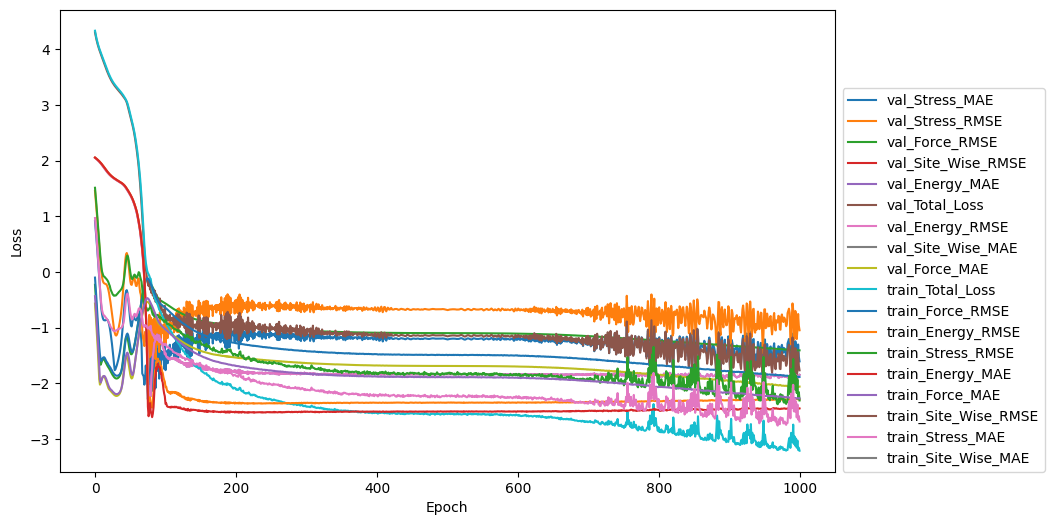

In [20]:
# Get the list of loss column names
loss_columns = [col for col in df.columns if col.startswith('val_') or col.startswith('train_')]

# Create a figure and axis
fig = plt.subplots(figsize=(10, 6))

# Plot each loss
for loss_column in loss_columns:
    plt.plot(df.index, np.log(df[loss_column]), label=loss_column)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=(1.01, 0))
plt.savefig(f'm3gnet_loss.eps', dpi=dpi, bbox_inches='tight')
plt.show()

In [21]:
df['val_Energy_MAE'].iloc[-2], df['val_Force_MAE'].iloc[-2], df['val_Stress_MAE'].iloc[-2]

(0.1576159596443176, 0.12761290371418, 0.2007803916931152)

In [22]:
df['val_Energy_MAE'].iloc[-1], df['val_Force_MAE'].iloc[-1], df['val_Stress_MAE'].iloc[-1]

(0.0, 0.0, 0.0)

# Cleanup the notebook

In [7]:
# This code just performs cleanup for this notebook from temporal files

patterns = ['dgl_graph*.bin', 'dgl_line_graph*.bin', 'state_attr*.pt', 'labels*.json', '*labels.txt']
for pattern in patterns:
    files = glob.glob(pattern)
    for file in files:
        try:
            os.remove(file)
        except FileNotFoundError:
            pass

#shutil.rmtree('logs')
#shutil.rmtree('trained_model')
#shutil.rmtree('finetuned_model')

NameError: name 'glob' is not defined